<a href="https://colab.research.google.com/github/cgurkan/fake-news/blob/main/FakeNewsDetection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection

- Preprocess
- Build Model With CNN and LSTM

## Import Libraries

In [1]:
# clean-text package is used for text processing
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=728d89a2562bfbe34f74132022993b38b6a92a59c148588631097de0b98f6ea1
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [2]:
import sys
import math
import pandas as pd
import numpy as np

import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.corpus import names ,wordnet, stopwords
from unicodedata import category
from cleantext import clean

#Data Visualisation

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

#Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score, f1_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot, Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional,Activation, Dropout,GlobalMaxPool1D, Conv1D
from keras.models import Model
from keras.utils import pad_sequences, plot_model
from keras import utils
from keras.optimizers import Adam

In [3]:
# Google Drive is used for to store unprocessed/processed dataset 
BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [4]:
# Read Training Dataset
df_train = pd.read_csv(BASE_URL+"data/train/Task3_english_training.csv")
df_train.head()

,public_id,text,title,our rating
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",FALSE
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,partially false
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,partially false
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,FALSE
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,FALSE


In [5]:
# Read Development Dataset ( will be merged with Training Dataset)
df_dev = pd.read_csv(BASE_URL+"data/train/Task3_english_dev.csv")
df_dev.head()

,public_id,text,title,our rating
0,81a67c96,Former state House Majority Leader Adam Hasner...,- The Washington Post,partially false
1,6e5ec6fb,"Editor’s note: Subsequent to this article, VTD...",Rubio Comments on Iran Nuclear Deal,false
2,d9cd4895,The hypocritical Lib Dems want to ignore the r...,Climate Alarmists Caught Manipulating Temperat...,false
3,4a1a9b9f,Urgent action to boost the number of children ...,Who are the arsonists setting rural fires in W...,false
4,6d16fa40,By Ken Allen AFSCME Council 75 represents the ...,"Diabetes prescriptions now cost NHS £1bn, figu...",false


In [6]:
# Read Test  Dataset ( will be merged with Training Dataset)
df_test = pd.read_csv(BASE_URL+"data/test/English_data_test_release_with_rating.csv")
df_test.head()

,ID,text,title,our rating
0,122653045997905671927713471889615536378,The deputy secretary at the US Treasury has sa...,US Treasury deputy sec warns that shortages li...,Partially false
1,275389285957305997321446227088442471741,KABUL—Approximately twelve minutes after U.S. ...,CNN Praises Taliban For Wearing Masks During A...,Other
2,333248764296609831067233855420575814716,The vast majority of (oblivious) Americans hav...,Tennessee Has Just LEGALIZED Government COVID ...,false
3,264019763253447756851916399533799891538,(Natural News) There’s a secret layer of infor...,MEDICAL SHOCKER: Scientists at Sloan Kettering...,false
4,158073737187690682830899773280916034317,"A recent study reported by the NCBI, which is ...",Study Results: Facemasks are Ineffective to Bl...,false


In [7]:
print(f"Training Data Shape: {df_train.shape} \nDev Data Shape: {df_dev.shape}  \nTest Data Shape: {df_test.shape}")

Training Data Shape: (900, 4) 
Dev Data Shape: (364, 4)  
Test Data Shape: (612, 4)


## Preprocessing

In this section, we'll process the data to be used in the model.

In [8]:
#Drop public_id column bot train and test dataset
df_train.drop(labels='public_id', axis=1, inplace=True)
df_dev.drop(labels='public_id', axis=1, inplace=True)
df_test.drop(labels='ID', axis=1, inplace=True)

In [9]:
#Rename target column to "label"
df_train.rename(columns={"our rating":"label"}, inplace=True)
df_dev.rename(columns={"our rating":"label"}, inplace=True)
df_test.rename(columns={"our rating":"label"}, inplace=True)

In [10]:
# Normalize and Map Target column data. There should be four class (0: 'False', 1:'True', 2:'Partially False',  3:'Other')
df_train['label'] = df_train.label.map({'TRUE': 1, 'True':1, 'true':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_train["label_name"] = df_train.label.map({0: 'False', 1:'True', 2:'Partially False',  3:'Other'})

df_dev['label'] = df_dev.label.map({'TRUE': 1, 'True':1, 'true':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_dev["label_name"] = df_dev.label.map({0: 'False', 1:'True', 2:'Partially False',  3:'Other'})

df_test['label'] = df_test.label.map({'TRUE': 1, 'True':1, 'true':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_test["label_name"] = df_test.label.map({0: 'False', 1:'True', 2:'Partially False',  3:'Other'})

In [11]:
#clear NaN values with space, we don't use title
df_train['title'] = df_train['title'].replace(math.nan,' ')
df_dev['title'] = df_train['title'].replace(math.nan,' ')
df_test['title'] = df_test['title'].replace(math.nan,' ')

In [12]:
#concatenate text and title columns
df_train["title_text"] = df_train["title"] + ' ' + df_train["text"]
df_dev["title_text"] = df_train["title"] + ' ' + df_train["text"]
df_test["title_text"] = df_test["title"] + ' ' + df_test["text"]

In [13]:
# Merge Training and Dev data to create single Training data
df = pd.concat([df_train, df_dev]).reset_index(drop = True)

In [14]:
#Drop not required data from dataset
df.drop(labels='text', axis=1, inplace=True)
df.drop(labels='title', axis=1, inplace=True)

In [15]:
#Drop not required data from dataset
df_test.drop(labels='text', axis=1, inplace=True)
df_test.drop(labels='title', axis=1, inplace=True)

In [16]:
#Save dataset to drive
def save_to_drive(df, path):
  from google.colab import files  

  with open(path, 'w') as f:
    df.to_csv(f)

In [17]:
# downloading NLTK package data
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Lemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

punctuations =  [chr(i) for i in range(sys.maxunicode) if category(chr(i)).startswith("P")]


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def tokenizer(text):
    return word_tokenize(text)
    ##return word_tokenize(text)[:500]


def remove_punctuation(tokens):
    no_punctiation = [token for token in tokens if token not in punctuations]
    return no_punctiation


def remove_stopwords(tokens):
    no_stopwords= [token for token in tokens if token not in stopwords]
    return no_stopwords


def lemmatizer(tokens): 
  lemmatized = [wordnet_lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
  return lemmatized


def tokens_to_text(tokens):
    text = "".join([token+" " for token in tokens])[:-1]
    return text


# Cleaning articles( lowercasing, replacing URL, EMAIL, PHONE Numbers, DIGIT, CURRENCY with special code in order not to lose information)
# Used clean-text package 
def general_cleaning(text):
    return clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUMBER",
    replace_with_digit="",
    replace_with_currency_symbol="CURRENCY",
    lang="en"                 
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


 Preprocess dataset

In [18]:
%%time
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_processing(df_temp, column_name):
  df_temp[column_name] = df_temp[column_name].progress_apply(lambda x:general_cleaning(x))
  print("General cleaning with clean-text library.")
  df_temp[column_name] = df_temp[column_name].apply(lambda x:tokenizer(x))
  print("Tokenized is finished.")
  df_temp[column_name]= df_temp[column_name].apply(lambda x:remove_stopwords(x))
  print("Stop-words has been removed.")
  df_temp[column_name]= df_temp[column_name].apply(lambda x:lemmatizer(x))
  print("Tokens have been lemmatized.")
  df_temp[column_name]= df_temp[column_name].apply(lambda x:tokens_to_text(x))
  print("Tokens have been convert to text.")
  return df_temp

CPU times: user 7.58 ms, sys: 0 ns, total: 7.58 ms
Wall time: 18.6 ms


In [19]:
#Save orginal dataset
training_path = BASE_URL + 'data/processed/fakenews_training.csv'
test_path = BASE_URL + 'data/processed/fakenews_test.csv'

save_to_drive(df, training_path)
save_to_drive(df_test, test_path)

In [20]:
#Save preprocessed tokenized dataset
training_path = BASE_URL + 'data/processed/fakenews_training_processed.csv'
test_path = BASE_URL + 'data/processed/fakenews_test_processed.csv'

df = text_processing(df, "title_text")
save_to_drive(df, training_path)

df_test = text_processing(df_test, "title_text")
save_to_drive(df_test, test_path)

  0%|          | 0/1264 [00:00<?, ?it/s]

General cleaning with clean-text library.
Tokenized is finished.
Stop-words has been removed.
Tokens have been lemmatized.
Tokens have been convert to text.


  0%|          | 0/612 [00:00<?, ?it/s]

General cleaning with clean-text library.
Tokenized is finished.
Stop-words has been removed.
Tokens have been lemmatized.
Tokens have been convert to text.


In [21]:
#preprocessed dataset
df.title_text[0]

'fin currency passenger use mobile phone start next week distract drive cause death canada impaired drive every province territory law drive operating cell phone tell passenger stay phone drive measure necessary distract drive claimed life impaired drive province like british columbia ontario quebec alberta nova scotia manitoba newfoundland labrador mobile phone even held passenger dangerous distraction driver start next week distract screen held passenger attracts penalty currency three demerit point driver screen mix doesnt matter hold device use facetime take selfies driver show driver funny cat video nono province mobile phone categorise visual display unit meaning consider akin television screen important practice safe drive sake fellow driver canada crack distract drive problem rollout stricter law impose harsher penalty heftier fine guilty offender take effect next week add serious penalty convict distract drive'

In [22]:
df_train.title_text[0]

'You Can Be Fined $1,500 If Your Passenger Is Using A Mobile Phone, Starting Next Week Distracted driving causes more deaths in Canada than impaired driving .It’s why every province and territory has laws against driving while operating a cell phone. “Tell your passengers to stay off their phones while you are driving. Such measures are more than necessary now, as distracted driving has claimed more lives than impaired driving in provinces like British Columbia, Ontario, Quebec, Alberta, Nova Scotia, Manitoba, Newfoundland and Labrador. “Mobile phones, even when held by a passenger, can be a dangerous distraction for the driver. Starting next week being distracted by a screen held by a passenger attracts a penalty of $1,500 and three demerit points. “Drivers and screens do not mix – it doesn’t matter who is holding the device. Using FaceTime, taking selfies with the driver or showing the driver a funny cat video is a no-no.” In most provinces a mobile phone is categorised as a “visual 

## Feature Extraction

In [23]:
# The Total unique Words In The Dataset
list_of_words = []
for doc in df.title_text:
  tokens = nltk.word_tokenize(doc)
  for j in tokens:
    list_of_words.append(j)

# Obtaining The Total Number Of Unique Words
total_words = len(list(set(list_of_words)))
total_words

24293

In [24]:
maxlen = -1
for doc in df.title_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 3614


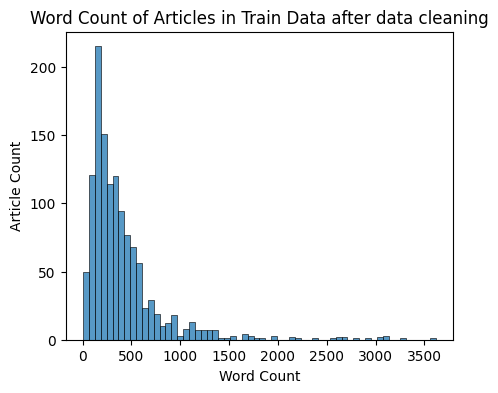

In [25]:
df['word_count'] = df['title_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(5,4))
sns.histplot(data=df, x='word_count')
plt.title('Word Count of Articles in Train Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [26]:
train_articles = (sum(df['word_count'] < 1250)/df.shape[0])*100
print('Percentage of Training Articles having less than 1250 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 1250 Words:95.97%


In [27]:
#Split dataset
x_train,x_test,y_train,y_test = df.title_text, df_test.title_text, df.label, df_test.label

In [28]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  
print("Vocabulary Size:",vocab_size)

Vocabulary Size: 24269


In [29]:
maxlen=1250
# Adding Padding
padded_train = pad_sequences(train_sequences ,maxlen = maxlen, padding = 'post')
padded_test = pad_sequences(test_sequences,   maxlen = maxlen, padding = 'post') 

In [30]:
# 1264 articke, 1250 token (we cut # of the token to 1250)
print(padded_train.shape)

(1264, 1250)


In [31]:
#Turn Labels in to categorical 
encoder = LabelEncoder()
encoder.fit(y_train)
train_y = encoder.transform(y_train)
test_y = encoder.transform(y_test)

num_classes = np.max(train_y) + 1
train_y = utils.to_categorical(train_y, num_classes)
test_y = utils.to_categorical(test_y, num_classes)

In [32]:
train_y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## Utility Functions

Some utiltiy functions such as 
- learning curve finder
- plot the learning curve
- print confusion matrix,

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


# Extracted from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Building Model

### CNN Model

In [35]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 100)         2426900   
                                                                 
 conv1d (Conv1D)             (None, 1246, 128)         64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Epoch 1/20
10/10 [==============================] - 9s 63ms/step - loss: 1.3849 - accuracy: 0.2832
Epoch 2/20
10/10 [==============================] - 0s 31ms/step - loss: 1.3785 - accuracy: 0.2801
Epoch 3/20
10/10 [==============================] - 0s 31ms/step - loss: 1.3712 - accuracy: 0.2872
Epoch 4/20
10/10 [==============================] - 0s 31ms/step - loss: 1.3583 - accuracy: 0.2896
Epoch 5/20
10/10 [==============================] - 0s 31ms/step - loss: 1.3390 - accuracy: 0.3252
Epoch 6/20
10/10 [==============================] - 0s 31ms/step - loss: 1.3027 - accuracy: 0.4407
Epoch 7/20
10/10 [==============================] - 0s 31ms/step - loss: 1.2608 - accuracy: 0.4778
Epoch 8/20
10/10 [==============================] - 0s 31ms/step - loss: 1.2124 - accuracy: 0.4660
Epoch 9/20
10/10 [==============================] - 0s 31ms/step - loss: 1.1700 - accuracy: 0.4604
Epoch 10/20
10/10 [==============================] - 0s 31ms/step - loss: 1.0860 - accuracy: 0.5435
Epoch 11/

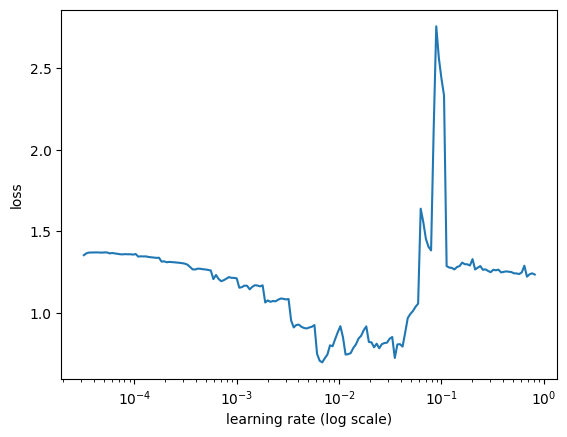

In [36]:
lr_finder = LRFinder(model)
lr_finder.find(padded_train, train_y, start_lr=0.00001, end_lr=1, batch_size=128, epochs=20)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

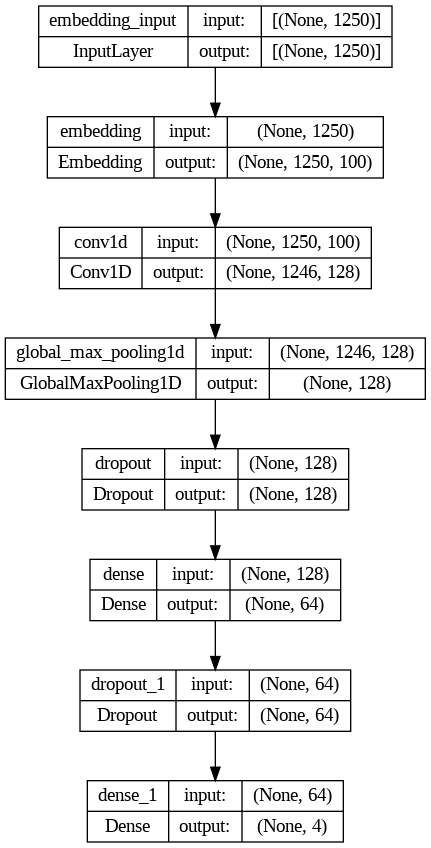

In [37]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [38]:
history = model.fit(padded_train, train_y,
                    batch_size=128,
                    epochs=20,
                    validation_data=(padded_test, test_y))

Epoch 1/20
10/10 [==============================] - 1s 99ms/step - loss: 1.2988 - accuracy: 0.4043 - val_loss: 1.2807 - val_accuracy: 0.5147
Epoch 2/20
10/10 [==============================] - 0s 41ms/step - loss: 1.1776 - accuracy: 0.4699 - val_loss: 1.2407 - val_accuracy: 0.5147
Epoch 3/20
10/10 [==============================] - 0s 41ms/step - loss: 1.0333 - accuracy: 0.5348 - val_loss: 1.1760 - val_accuracy: 0.5098
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 0.8602 - accuracy: 0.6456 - val_loss: 1.3507 - val_accuracy: 0.4837
Epoch 5/20
10/10 [==============================] - 0s 42ms/step - loss: 0.7526 - accuracy: 0.7191 - val_loss: 1.4236 - val_accuracy: 0.4395
Epoch 6/20
10/10 [==============================] - 0s 43ms/step - loss: 0.6307 - accuracy: 0.7405 - val_loss: 1.5634 - val_accuracy: 0.2157
Epoch 7/20
10/10 [==============================] - 0s 42ms/step - loss: 0.5592 - accuracy: 0.7666 - val_loss: 1.4970 - val_accuracy: 0.1928
Epoch 8/20
10

In [39]:
loss, accuracy = model.evaluate(padded_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_test, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7967
Testing Accuracy:  0.4379


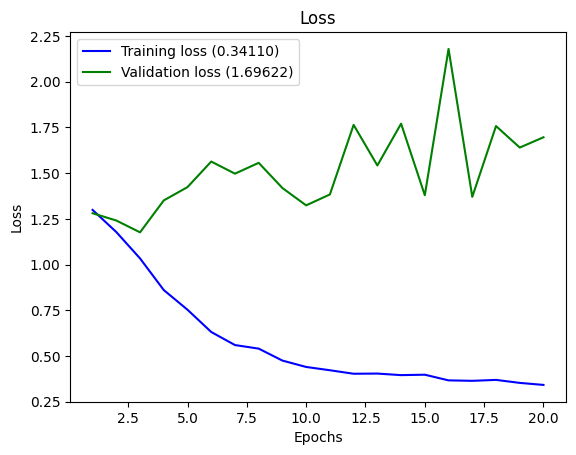

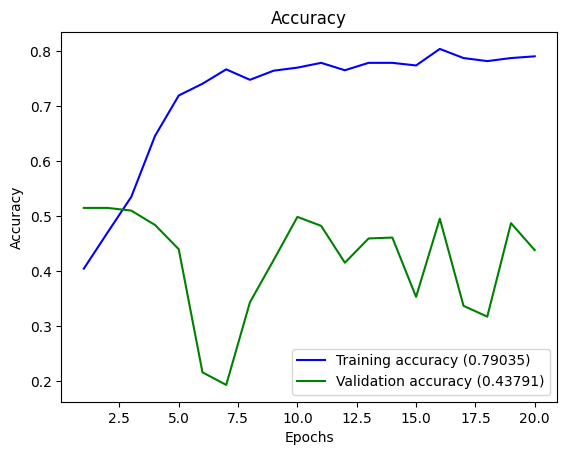

In [40]:
plot_history(history)

In [41]:
#Evaluation
y_prediction = model.predict(padded_test)
y_prediction = np.argmax (y_prediction, axis = 1)
result_ = confusion_matrix(y_test, y_prediction)

20/20 [==============================] - 0s 3ms/step


In [42]:
#Print Classification Report
print(classification_report(y_test, y_prediction, zero_division=1))

              precision    recall  f1-score   support

           0       0.51      0.81      0.63       315
           1       0.25      0.03      0.06       210
           2       0.08      0.07      0.08        56
           3       0.05      0.06      0.06        31

    accuracy                           0.44       612
   macro avg       0.22      0.24      0.21       612
weighted avg       0.36      0.44      0.35       612



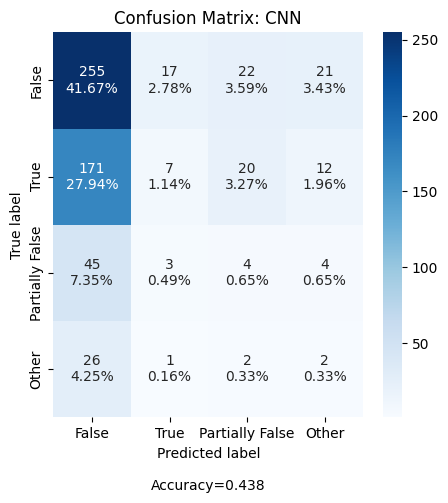

In [45]:
#Plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result_,
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      figsize=(5,5),
                      cbar=True, title='Confusion Matrix: CNN', sum_stats=True)

### LSTM

In [46]:
embedding_dim = 100

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model1.add(Bidirectional(LSTM(128, dropout=0.5)))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1250, 100)         2426900   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2,694,808
Trainable params: 2,694,808
Non-trainable params: 0
_________________________________________________________________


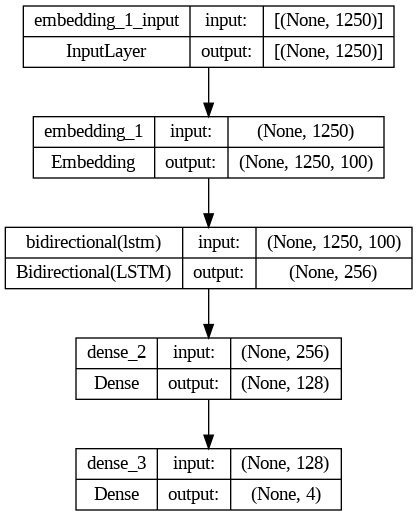

In [47]:
plot_model(model1, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

In [48]:
history_1 = model1.fit(padded_train, train_y,
                    batch_size=128,
                    epochs=20,
                    validation_data=(padded_test, test_y))

Epoch 1/20
10/10 [==============================] - 13s 472ms/step - loss: 1.3025 - accuracy: 0.4248 - val_loss: 1.2721 - val_accuracy: 0.5147
Epoch 2/20
10/10 [==============================] - 4s 399ms/step - loss: 1.2349 - accuracy: 0.4573 - val_loss: 1.2475 - val_accuracy: 0.5147
Epoch 3/20
10/10 [==============================] - 3s 349ms/step - loss: 1.2146 - accuracy: 0.4573 - val_loss: 1.2485 - val_accuracy: 0.5147
Epoch 4/20
10/10 [==============================] - 3s 350ms/step - loss: 1.1467 - accuracy: 0.4581 - val_loss: 1.2384 - val_accuracy: 0.5147
Epoch 5/20
10/10 [==============================] - 4s 415ms/step - loss: 1.4742 - accuracy: 0.5807 - val_loss: 1.3245 - val_accuracy: 0.2843
Epoch 6/20
10/10 [==============================] - 4s 386ms/step - loss: 1.0776 - accuracy: 0.6653 - val_loss: 1.2879 - val_accuracy: 0.4902
Epoch 7/20
10/10 [==============================] - 3s 352ms/step - loss: 0.9107 - accuracy: 0.6479 - val_loss: 1.3544 - val_accuracy: 0.4379
Epoch

In [49]:
loss, accuracy = model1.evaluate(padded_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(padded_test, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8014
Testing Accuracy:  0.4314


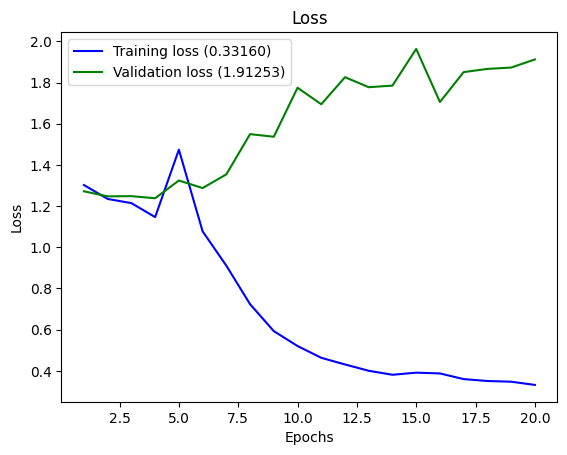

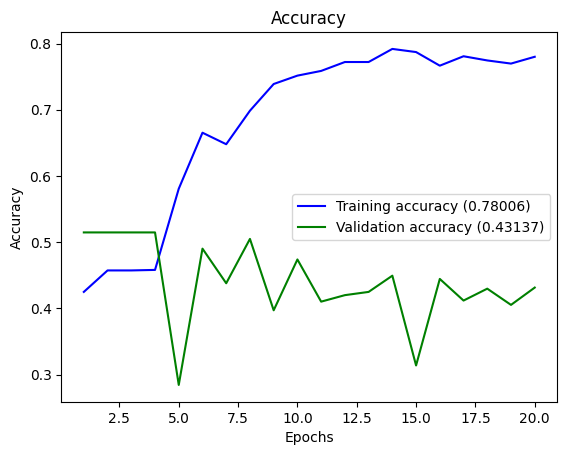

In [50]:
plot_history(history_1)

In [51]:
#Evaluation
y_prediction_1 = model.predict(padded_test)
y_prediction_1 = np.argmax (y_prediction_1, axis = 1)
result_1 = confusion_matrix(y_test, y_prediction_1)

20/20 [==============================] - 0s 4ms/step


In [52]:
#Print Classification Report
print(classification_report(y_test, y_prediction_1, zero_division=1))

              precision    recall  f1-score   support

           0       0.51      0.81      0.63       315
           1       0.25      0.03      0.06       210
           2       0.08      0.07      0.08        56
           3       0.05      0.06      0.06        31

    accuracy                           0.44       612
   macro avg       0.22      0.24      0.21       612
weighted avg       0.36      0.44      0.35       612



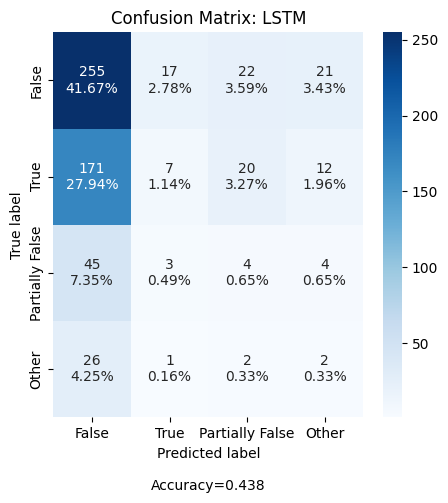

In [53]:
#Plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      figsize=(5,5),
                      cbar=True, title='Confusion Matrix: LSTM', sum_stats=True)